<a href="https://colab.research.google.com/github/shashidhanekula96/Gauguin-Bot-and-Data-Journalism-by-shashi/blob/master/Gauguin_Resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I have concept of transfer learning. I have utilized a Resent-50 pre trained model and trained the model with my image dataset. This model is trained to predict classes of 11 different types of graphs with an accuracy of 76%. 

The graphs are Area Graph, Bar charts, Bubble Chart, Piecharts, Arc diagram, Box and Whisker Plot, Brainstorm chart, Bubble Map, Bullet Graph, Candlestick Chart, Heatmap and Bar chart.

Using keras in tensorflow I have imported required packages and libraries to train the model.
   
   Intially, I have extracted the various types of charts from google images using 'Web scrapping' in python. 
  Next I trained a CNN model using Resnet 50 pre-trained model.

**Required Libraries**

In [ ]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import tensorflow as tf
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Intializing hyper parameters for the model

In [ ]:
# Number of classes
NUM_CLASSES = 11

# Required channel for color images
CHANNELS = 3

# Standard Resnet 50 Image size and parameters
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

**Uploading Data**

In [ ]:
#using zipfile package extracting the data zipfileinto colab environment
from zipfile import ZipFile
Charts_new = "Charts.zip"

with ZipFile(Charts_new,'r') as zip:
  zip.extractall()
  print('done')

Segregating data into Train, Test and Validation data sets

In [ ]:

import os
import numpy as np
import shutil
import random

## Creating Train/Val/Test folders (One time use)
root_dir = '/content/Charts'
classes_dir = ['Area Graph', 'Bar charts', 'Bubble Chart', 'Piecharts','Arc diagram',
               'Box and Whisker Plot','Brainstorm chart','Bubble Map','Bullet Graph',
               'Candlestick Chart','Heatmap']

for cls in classes_dir:
    os.makedirs(root_dir +'/train' +'/'+ cls)
    os.makedirs(root_dir +'/val' +'/'+ cls)
    os.makedirs(root_dir +'/test' +'/'+ cls)

    # Creating partitions of the data after shuffeling
    src = root_dir + "/" + cls # Folder to copy images from

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.6), int(len(allFileNames)*0.85)])


    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train'+'/'+ cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/test' +'/'+ cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/val' +'/'+ cls)


Total images:  97
Training:  67
Validation:  15
Testing:  15
Total images:  205
Training:  143
Validation:  31
Testing:  31
Total images:  267
Training:  186
Validation:  40
Testing:  41
Total images:  189
Training:  132
Validation:  28
Testing:  29
Total images:  66
Training:  46
Validation:  10
Testing:  10
Total images:  32
Training:  22
Validation:  5
Testing:  5
Total images:  73
Training:  51
Validation:  11
Testing:  11
Total images:  446
Training:  312
Validation:  67
Testing:  67
Total images:  337
Training:  235
Validation:  51
Testing:  51
Total images:  99
Training:  69
Validation:  15
Testing:  15
Total images:  32
Training:  22
Validation:  5
Testing:  5


Image Resizing and Preprocessing using Image data generator.

In [ ]:
image_size = IMAGE_RESIZE

# Each image is resized to the required value. Inorder to increase the data the augementation techinique is applied to resized image dataset.(resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train = root_dir + '/train'
train_generator = data_generator.flow_from_directory(
        train,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

Found 1285 images belonging to 11 classes.


In [ ]:
valid = root_dir + '/val'
validation_generator = data_generator.flow_from_directory(
        valid,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

Found 280 images belonging to 11 classes.


In [ ]:
# len(train_generator) should be 'no. of available train images / BATCH_SIZE_TRAINING'
# len(valid_generator) should be 'no. of available train images / BATCH_SIZE_VALIDATION'
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 13, 100, 3)

Importing Resnet 50 model. 

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, 
    weights="imagenet", 
    pooling='avg'))
model.add(Dense(11, activation = 'softmax'))  # Final layer added and activation is softmax as we 1 or 0 as output.
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 11)                22539     
Total params: 23,610,251
Trainable params: 22,539
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
from tensorflow.python.keras import optimizers

sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)  # learning ratio is assigned small to avoid improper model learning.
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs = 10,
        validation_data=validation_generator,
        validation_steps=10)

In [ ]:
model.save("resnet50_1.h5")

In [ ]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Illustrating performance measures

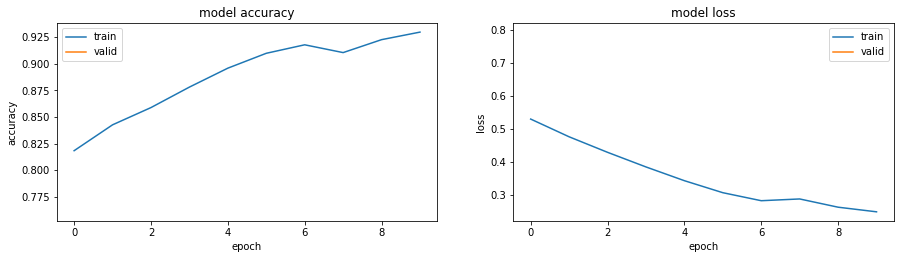

In [ ]:
 plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [ ]:
test = root_dir + '/test'
test_generator = data_generator.flow_from_directory(
    directory = test,
    target_size = (image_size, image_size),
    batch_size = BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)

Found 278 images belonging to 11 classes.


In [ ]:
test_generator.reset()

# Predicting the clases of test data using trained model

pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.
278/278 [==============================] - 6s 20ms/step


In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    labels=['Area Graph', 'Bar charts', 'Bubble Chart', 'Piecharts','Arc diagram',
               'Box and Whisker Plot','Brainstorm chart','Bubble Map','Bullet Graph',
               'Candlestick Chart','Heatmap']
    sns.heatmap(C, annot=True, cmap="YlGnBu",fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Confusion Matrix for test data

-------------------- Confusion matrix --------------------


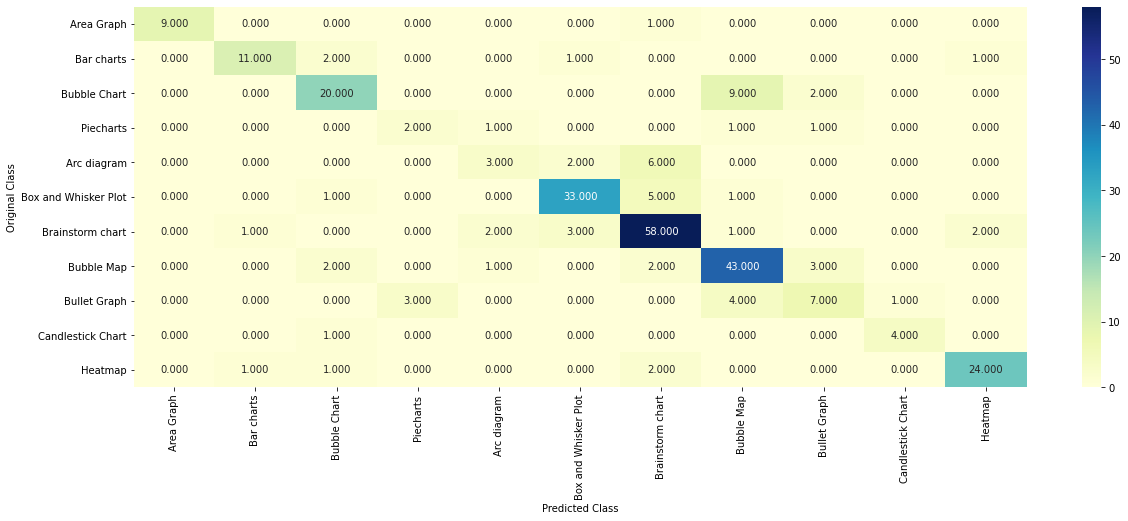

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_pred = np.argmax(pred, axis=1)
plot_confusion_matrix(test_generator.classes, y_pred)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(pred, axis=1)
print('Classification Report')
target_names = ['Area Graph', 'Bar charts', 'Bubble Chart', 'Piecharts','Arc diagram',
               'Box and Whisker Plot','Brainstorm chart','Bubble Map','Bullet Graph',
               'Candlestick Chart','Heatmap']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
                      precision    recall  f1-score   support

          Area Graph       1.00      0.90      0.95        10
          Bar charts       0.85      0.73      0.79        15
        Bubble Chart       0.74      0.65      0.69        31
           Piecharts       0.40      0.40      0.40         5
         Arc diagram       0.43      0.27      0.33        11
Box and Whisker Plot       0.85      0.82      0.84        40
    Brainstorm chart       0.78      0.87      0.82        67
          Bubble Map       0.73      0.84      0.78        51
        Bullet Graph       0.54      0.47      0.50        15
   Candlestick Chart       0.80      0.80      0.80         5
             Heatmap       0.89      0.86      0.87        28

            accuracy                           0.77       278
           macro avg       0.73      0.69      0.71       278
        weighted avg       0.77      0.77      0.76       278



In [ ]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'predicted': pd.Series(predicted_class_indices)
    })
results_df[120:170]

In [ ]:
correct = np.nonzero(y_pred == test_generator.classes)[0]
incorrect = np.nonzero(y_pred != test_generator.classes)[0]

In [ ]:
print("Misclassified Images: {:.2f}".format((len(incorrect)/(len(correct)+len(incorrect)))*100))
print("Classified Images: {:.2f}".format((len(correct)/(len(correct)+len(incorrect)))*100))

Misclassified Images: 23.02
Classified Images: 76.98


For testing different models

New Model with Higher trainable parameters

In [ ]:
# A Vgg-16 model is hardcoded

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
#Can use for extra layers
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=11, activation="softmax"))


In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 256)      

In [ ]:

from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model.fit_generator(train_generator,steps_per_epoch=25,validation_data=validation_generator,
                           validation_steps=10,epochs=25,
                           callbacks=[checkpoint,early])